<a href="https://colab.research.google.com/github/kevinwatkins/deep-learning-sandbox/blob/master/eleutherai/EleutherAI_training_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import io, re, time, ast, requests, json, IPython.display, numpy as np, matplotlib.pyplot as plt, matplotlib.image as mpimg
openai_image = None

## Tensorboard list

In [2]:
runs = np.array([
    'run-2',
    'gpt3-xl-replication-1',
    'run-4',

    'gpt3-small',
    'gpt3-175b',
])
# (url_stem, run_stem)
tensorboards = {
    'run-2': ('http://35.204.253.196:8106', ''),
    'gpt3-xl-replication-1': ('http://35.204.253.196:8042', ''),
    'run-4': ('http://35.204.253.196:8044/', ''),
}

## Hyperparameters

Some hyperparameters are given in a cell here; others are loaded from tensorboard. Some OpenAI GPT-3 models are included for comparison.

In [3]:
hparams = json.loads('''{

"run-2": {
    "n_head": 8,
    "n_vocab": 32768,
    "embed_dropout": 0.1,
    "lr": 0.0006,
    "warmup_steps": 3000,
    "beta1": 0.9,
    "beta2": 0.95,
    "epsilon": 1e-8,
    "opt_name": "adam",
    "weight_decay": 0.1,
    "lr_decay": "linear",
    "train_batch_size": 32,
    "attn_dropout": 0.1,
    "train_steps": 300000,
    "eval_steps": 0,
    "res_dropout": 0.1,
    "eval_batch_size": 32,
    "iterations": 500,
    "n_embd": 768,
    "datasets": [["gs://neo-datasets/openwebtext-new/openwebtext_*.tfrecords", "", 11, "documents_random", 1.0]],
    "model": "GPT2",
    "model_path": "gs://neo-models/Global_long_Benchmark",
    "n_ctx": 1024,
    "n_layer": 12,
    "scale_by_depth": true,
    "scale_by_in": true,
    "local": false,
    "mesh_shape": "all:8",
    "layout": "heads:all",
    "precision": "float32",
    "activation_function": "gelu",
    "microbatches_per_batch": 1
},

"gpt3-small": {
    "train_batch_size": 250,
    "train_steps": 585938,
    "n_head": 12,
    "n_vocab": 50257,
    "n_layer": 12,
    "n_embd": 768,
    "n_ctx": 2048,
    "mesh_shape": "dummy:1"
},

"gpt3-175b": {
    "train_batch_size": 1600,
    "train_steps": 91553,
    "n_head": 96,
    "n_vocab": 50257,
    "n_layer": 96,
    "n_embd": 12288,
    "n_ctx": 2048,
    "mesh_shape": "dummy:1"
}

}''')

## Data loading

The last cell in this section will attempt to load data from all the tensorboards and create (or overwrite) local copies. The rest of the notebook operates on the local copies.

In [4]:
def run_hparams_path(run):
    return f'{run}-hparams.json'
def run_data_path(run):
    return f'{run}.json'

In [5]:
def get_hparams(run):
    if run in hparams:
        return hparams[run]
    url_stem, run_stem = tensorboards[run]
    url = f'{url_stem}/data/plugin/text/text'
    try:
        resp = requests.get(url, params={
            'tag': 'run_config',
            'run': f'{run_stem}config',
        })
        resp.raise_for_status()

        # wheeeeeeeeeee
        json1 = resp.json()
        text1 = json1[0]['text']
        text2 = re.sub('<p>(.*)</p>', '\\1', text1)
        return ast.literal_eval(text2)
    except:
        return None

def get_run_data(run):
    url_stem, run_stem = tensorboards[run]
    url = f'{url_stem}/data/plugin/scalars/scalars'
    try:
        resp = requests.get(url, params={
            'tag': 'loss',
            'run': f'{run_stem}.',
            'experiment': '',
        })
        resp.raise_for_status()
        return resp.text
    except:
        return None

def update_hparams(run):
    hparams = get_hparams(run)
    if hparams:
        with open(run_hparams_path(run), 'w') as f:
            f.write(json.dumps(hparams))
        print(f'refreshed {run} hparams')
    else:
        print(f'no luck refreshing {run} hparams')

def update_run_data(run):
    data = get_run_data(run)
    if data:
        with open(run_data_path(run), 'w') as f:
            f.write(data)
        print(f'refreshed {run}')
    else:
        print(f'no luck refreshing {run}')

In [6]:
for run in runs:
    if run in tensorboards and run not in hparams:
        update_hparams(run)
    if run in tensorboards:
        update_run_data(run)

refreshed run-2
refreshed gpt3-xl-replication-1 hparams
refreshed gpt3-xl-replication-1
refreshed run-4 hparams
refreshed run-4


## Reformatting data as numpy arrays

In [7]:
def load_hparams(run):
    if run in hparams:
        return hparams[run]
    with open(run_hparams_path(run), 'r') as f:
        return json.load(f)
def load_run_data(run):
    try:
        with open(run_data_path(run), 'r') as f:
            return json.load(f)
    except:
        return []
run_hparams_dict = {run: load_hparams(run) for run in runs}
run_data_list = [load_run_data(run) for run in runs]

In [8]:
def hparray(key):
    return np.array([run_hparams_dict[run][key] for run in runs])

In [9]:
train_batch_size = hparray('train_batch_size')
n_head = hparray('n_head')
n_vocab = hparray('n_vocab')
n_layer = hparray('n_layer')
n_embd = hparray('n_embd')
n_ctx = hparray('n_ctx')
mesh_shape = hparray('mesh_shape')
train_steps = hparray('train_steps')

In [10]:
n_rows = np.array([len(d) for d in run_data_list])
run_data = np.full([len(runs), max(n_rows), 3], np.nan)
for i in range(len(runs)):
    data = run_data_list[i]
    if len(data) > 0:
        run_data[i, :len(data), :] = np.array(data)

In [11]:
def get_n_cores(mesh_shape):
    dims = mesh_shape.split(',')
    dim_lens = [int(dim.split(':')[1]) for dim in dims]
    return np.prod(dim_lens)

In [12]:
wall_time = run_data[:, :, 0]
step = run_data[:, :, 1]
loss = run_data[:, :, 2]

## Further calculated quantities

In [13]:
nz_rows = np.nonzero(n_rows)
nz_last_row = n_rows[nz_rows]-1
def last(a):
    r = np.full(len(runs), np.nan)
    r[nz_rows] = a[nz_rows, nz_last_row]
    return r

wall_elapsed = last(wall_time) - wall_time[:, 0]
batches_elapsed = last(step) - step[:, 0]
wall_per_batch = wall_elapsed/batches_elapsed
tokens_per_sec = train_batch_size*n_ctx/wall_per_batch
last_update_time = last(wall_time)
end_step = last(step)
end_loss = last(loss)
fraction_done = end_step/train_steps
flops_per_core = 52.5e12
n_cores = np.array([get_n_cores(shape) for shape in mesh_shape], dtype=float)
total_flops = flops_per_core*n_cores
approx_model_params = n_layer*(n_embd.astype(float)**2)*12 + n_vocab*n_embd.astype(float)
total_train_tokens = train_steps*n_ctx*train_batch_size.astype(float)
total_approx_ops = approx_model_params*total_train_tokens*6
total_pflops_days = total_approx_ops/1e15/86400
train_tokens_elapsed = end_step*n_ctx*train_batch_size
approx_ops_elapsed = approx_model_params*train_tokens_elapsed*6
pflops_days_elapsed = approx_ops_elapsed/1e15/86400

theo_wall_per_batch = n_ctx*train_batch_size*approx_model_params*6/total_flops
theo_eff = theo_wall_per_batch/wall_per_batch
wall_remaining = (total_approx_ops-approx_ops_elapsed)/total_flops/theo_eff
est_finish_time = last_update_time + wall_remaining

row_train_tokens = step*n_ctx[:, np.newaxis]*train_batch_size[:, np.newaxis].astype(float)
row_approx_n_ops = approx_model_params[:, np.newaxis]*row_train_tokens*6
row_pflops_days = row_approx_n_ops/1e15/86400

## Model size comparison

In [14]:
md_text = []

def format_val(val, format_spec):
    if isinstance(val, float) and np.isnan(val):
        return ''
    elif format_spec == 'gmt':
        return time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(val))
    else:
        return format(val, format_spec)

def add_row(name, values=[], format_spec=''):
    global md_text
    md_text.append(f'| {name} ')
    md_text += [f'| {format_val(v, format_spec)} ' for v in values]
    md_text.append('|\n')

add_row(' ', runs)
add_row('----', ['----:' for r in runs])
add_row('**Model shape**')
add_row('n_head', n_head)
add_row('n_vocab', n_vocab)
add_row('n_layer', n_layer)
add_row('n_embd', n_embd)
add_row('n_ctx', n_ctx)
add_row('approx_model_params', approx_model_params, '.2e')
add_row('**Training size**')
add_row('train_batch_size', train_batch_size)
add_row('train_steps', train_steps)
add_row('total_train_tokens', total_train_tokens, '.2e')
add_row('total_approx_ops', total_approx_ops, '.2e')
add_row('total_pflops_days', total_pflops_days, '.2e')
add_row('**TPU**')
add_row('n_cores', n_cores, '.0f')
add_row('total_flops', total_flops, '.2e')
add_row('**Training progress**')
add_row('n_updates', n_rows)
add_row('last_update_time', last_update_time, 'gmt')
add_row('wall_time_secs', wall_elapsed, '.1f')
add_row('latest_batch', end_step, '.0f')
add_row('latest_loss', end_loss, '.2f')
add_row('fraction_done', fraction_done, '.4f')
add_row('train_tokens_elapsed', train_tokens_elapsed, '.2e')
add_row('approx_ops_elapsed', approx_ops_elapsed, '.2e')
add_row('pflops_days_elapsed', pflops_days_elapsed, '.2e')
add_row('secs_per_batch', wall_per_batch, '.2f')
add_row('tokens_per_sec', tokens_per_sec, '.0f')
add_row('theo_eff', theo_eff, '.3f')
add_row('wall_remaining_secs', wall_remaining, '.0f')
add_row('est_finish_time', est_finish_time, 'gmt')

display(
    IPython.display.HTML('''<style>
      table {
        table-layout: fixed;
        border-collapse: collapse;
        font-size: 9pt;
      }
      tbody tr:nth-child(odd) {
        background-color: #f0f0f0;
      }
      th {
        width: 115px;
      }
      td, th {
        padding: 2px 5px;
        /* text-align: right; */
      }
      /* td:nth-child(1) {
        font-style: italic;
      } */
    </style>'''),
    IPython.display.Markdown(''.join(md_text))
)

|   | run-2 | gpt3-xl-replication-1 | run-4 | gpt3-small | gpt3-175b |
| ---- | ----: | ----: | ----: | ----: | ----: |
| **Model shape** |
| n_head | 8 | 32 | 32 | 12 | 96 |
| n_vocab | 32768 | 50257 | 50257 | 50257 | 50257 |
| n_layer | 12 | 24 | 24 | 12 | 96 |
| n_embd | 768 | 2048 | 2048 | 768 | 12288 |
| n_ctx | 1024 | 2048 | 2048 | 2048 | 2048 |
| approx_model_params | 1.10e+08 | 1.31e+09 | 1.31e+09 | 1.24e+08 | 1.75e+11 |
| **Training size** |
| train_batch_size | 32 | 512 | 512 | 250 | 1600 |
| train_steps | 300000 | 300000 | 300000 | 585938 | 91553 |
| total_train_tokens | 9.83e+09 | 3.15e+11 | 3.15e+11 | 3.00e+11 | 3.00e+11 |
| total_approx_ops | 6.49e+18 | 2.47e+21 | 2.47e+21 | 2.22e+20 | 3.14e+23 |
| total_pflops_days | 7.52e-02 | 2.86e+01 | 2.86e+01 | 2.57e+00 | 3.64e+03 |
| **TPU** |
| n_cores | 8 | 256 | 256 | 1 | 1 |
| total_flops | 4.20e+14 | 1.34e+16 | 1.34e+16 | 5.25e+13 | 5.25e+13 |
| **Training progress** |
| n_updates | 70 | 20 | 2 | 0 | 0 |
| last_update_time | 2020-07-29 20:47:32 | 2020-07-30 17:14:25 | 2020-07-30 16:53:13 |  |  |
| wall_time_secs | 103292.9 | 92420.9 | 4525.0 |  |  |
| latest_batch | 104000 | 28000 | 2000 |  |  |
| latest_loss | 2.78 | 6.89 | 11.63 |  |  |
| fraction_done | 0.3467 | 0.0933 | 0.0067 |  |  |
| train_tokens_elapsed | 3.41e+09 | 2.94e+10 | 2.10e+09 |  |  |
| approx_ops_elapsed | 2.25e+18 | 2.31e+20 | 1.65e+19 |  |  |
| pflops_days_elapsed | 2.61e-02 | 2.67e+00 | 1.91e-01 |  |  |
| secs_per_batch | 1.00 | 3.36 | 3.02 |  |  |
| tokens_per_sec | 32834 | 312006 | 347591 |  |  |
| theo_eff | 0.052 | 0.183 | 0.203 |  |  |
| wall_remaining_secs | 195608 | 914126 | 898974 |  |  |
| est_finish_time | 2020-08-01 03:07:40 | 2020-08-10 07:09:51 | 2020-08-10 02:36:07 |  |  |


## Loss vs compute plot

Note: the "compute" axis is the theoretical pflops-days that would be consumed if the tensor operations could be run at 100% efficiency. In practice, the actual pflops-days will be greater. Also, the number of floating point operations is only approximated here.

Note 2: As of this writing, EleutherAI is using its own BPE vocabulary, so in theory, losses from EleutherAI and OpenAI cannot be directly compared.

In [15]:
show_openai_runs = True

### Implementation details

In [16]:
def download_openai_image():
    try:
        resp = requests.get('https://storage.googleapis.com/via-whereas/LanguageModelingComputePareto.png')
        resp.raise_for_status()
        return resp.content
    except:
        return None

In [17]:
def show_loss_compute_plot():
    global openai_image
    fig = plt.figure(figsize=(6.37, 6), dpi=100)

    if show_openai_runs:
        fig.add_subplot(label='image')
        if not openai_image:
            openai_image = download_openai_image()
        img = mpimg.imread(io.BytesIO(openai_image))
        plt.imshow(img[112:1520, 380:1912])
        plt.axis('off')

    ax = fig.add_subplot(label='runs')
    ax.patch.set_alpha(0)

    for i in range(len(runs)):
        plt.plot(row_pflops_days[i, :n_rows[i]], loss[i, :n_rows[i]], 'r')

    if not show_openai_runs:
        frontier_xs = np.array([1e-6, 1e4])
        frontier_ys = 2.57*(frontier_xs**-0.048)
        plt.plot(frontier_xs, frontier_ys, 'k:')

    plt.xlabel('Compute (pflops-days)')
    plt.xscale('log')
    plt.xlim(1e-6, 1e4)
    plt.xticks(10.**np.arange(-6, 6, 2))

    plt.ylabel('Loss')
    plt.yscale('log')
    plt.ylim(1.5, 6)
    y_ticks = [1.5] + list(range(2, 7))
    plt.yticks(y_ticks, labels=[str(t) for t in y_ticks])

    plt.grid(not show_openai_runs)
    plt.show()

### The plot

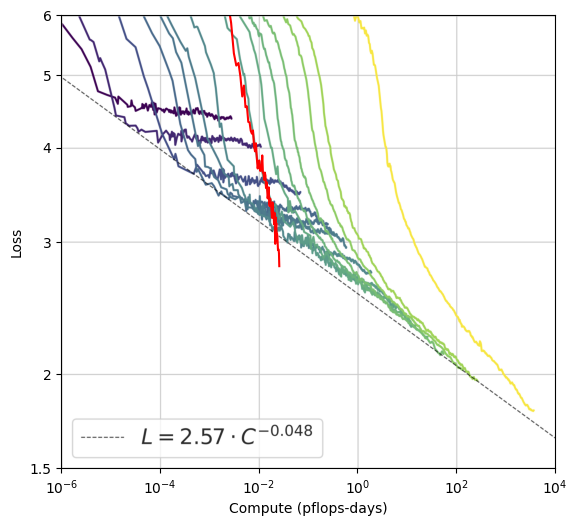

In [18]:
show_loss_compute_plot()